**Quora Question Pairs using Siamese Manhattan LSTM**

import all the necessary packages

In [35]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime
import tqdm

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta, Adam
from keras.callbacks import ModelCheckpoint

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Global variables

In [4]:
# File paths
TRAIN_CSV = '/content/drive/MyDrive/Deep Learning/quora-question-pairs/train.csv'
TEST_CSV = '/content/drive/MyDrive/Deep Learning/quora-question-pairs/test.csv'
EMBEDDING_FILE = '/content/drive/MyDrive/Deep Learning/quora-question-pairs/Copie de GoogleNews-vectors-negative300.bin.gz'
#MODEL_SAVING_DIR = '/home/ecohen/HDD/HDD4/Models/Kaggle/Quora/'

In [5]:
#import the nltk stopwords
import nltk
nltk.download("stopwords") 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Training and Test datasets

In [6]:
# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [7]:
print(train_df.shape)
train_df.head()

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
print(test_df.shape)
test_df.head()

(2345796, 3)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?



Create embedding matrix, using word2vec

In [9]:
#English stopwords
stops = set(stopwords.words('english'))


def text_to_word_list(text):
    ''' Pre process and convert texts to a list of lower case words '''
    text = str(text)
    text = text.lower()

    # Cleaning the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

questions_cols = ['question1', 'question2']


# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue
                    
                #vocabulary : words => indices
                #inverse_vocabulary : words where indx match id vocab

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            #dataset.set_value(index, question, q2n)
            dataset.at[index, question] = q2n 

#create embedding matrix         
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec #to free space

#length of embedding matrix
mat_emb = len(embeddings)
print(mat_emb)

121320


Prepare training and validation data

In [79]:
#the length of the longest question
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
#itertools.product gives all the combinations between the two lists
for dataset, side in itertools.product([X_train, X_validation, X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

assert X_test['left'].shape == X_test['right'].shape

Build the MaLSTM model

In [11]:
# Model variables
n_hidden = 50
#gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

# MaLSTM similarity function
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))
#Trying an other distance to compare : Cosine / euclidienne 

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                         output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
#optimizer = Adadelta(clipnorm=gradient_clipping_norm)
#malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

#Cross Entroy and normalize the gradients with RmsProp
#malstm.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#Trying MSE and Adam Optimizer !
malstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']],
                            Y_train, batch_size=batch_size, epochs=n_epoch, 
                            validation_data=([X_validation['left'],X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/25
5693/5693 [==============================] - 136s 24ms/step - loss: 0.1609 - accuracy: 0.7711 - val_loss: 0.1465 - val_accuracy: 0.7936
Epoch 2/25
5693/5693 [==============================] - 134s 24ms/step - loss: 0.1415 - accuracy: 0.8037 - val_loss: 0.1384 - val_accuracy: 0.8090
Epoch 3/25
5693/5693 [==============================] - 133s 23ms/step - loss: 0.1340 - accuracy: 0.8157 - val_loss: 0.1343 - val_accuracy: 0.8146
Epoch 4/25
5693/5693 [==============================] - 134s 24ms/step - loss: 0.1290 - accuracy: 0.8236 - val_loss: 0.1317 - val_accuracy: 0.8173
Epoch 5/25
5693/5693 [==============================] - 133s 23ms/step - loss: 0.1251 - accuracy: 0.8300 - val_loss: 0.1296 - val_accuracy: 0.8248
Epoch 6/25
5693/5693 [==============================] - 134s 24ms/step - loss: 0.1219 - accuracy: 0.8353 - val_loss: 0.1287 - val_accuracy: 0.8219
Epoch 7/25
5693/5693 [==============================] - 134s 23ms/step - loss: 0.1193 - accuracy: 0.8395 - val_loss: 0


Plotting the results

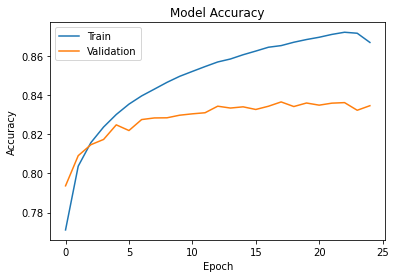

In [87]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


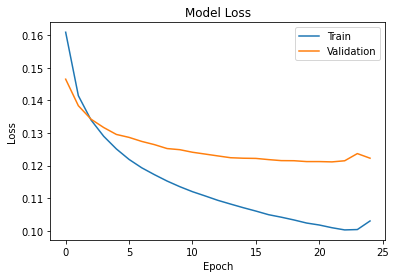

In [88]:
# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [77]:
#Saving the model
malstm.save('trained_model.h5')

Testing the model 

In [81]:
#Testing by a submission on Kaggle 

#Prediction
prediction = malstm.predict([X_test['left'], X_test['right']], verbose=1)

73307/73307 [==============================] - 776s 11ms/step


In [82]:
#Saving Predictions
np.savetxt('predictions.txt', prediction)

In [84]:
#Loading Predictions
predict = np.loadtxt('predictions.txt')

In [85]:
#Kaggle Submission File

data = {'test_id': np.arange(len(prediction)), 'is_duplicate': np.squeeze(prediction)} # squeeze to convert to one-dimensional
submission = pd.DataFrame(data, columns=data.keys()) # preserving order

In [86]:
submission.to_csv('submission_MaLSTM.csv', header=list(submission), index=False)